# Setup and Imports

In [1]:
!pip install SimpleITK
!pip install xlsxwriter
!pip -q install git+https://github.com/adalca/neurite.git@9ae2f5cec2201eedbcc6929cecf852193cef7646
!pip -q install git+https://github.com/voxelmorph/voxelmorph.git@364394f98db7426a2d61a0fc7227746c5aa0b672
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.2 MB/s eta 0:00:00


In [2]:
import os
import torch
import monai
from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    NormalizeIntensityD,
    ThresholdIntensityD,
    ResizeD,
    ToTensorD,
)
import time
import SimpleITK as sitk
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
from voxelmorph.torch.networks import VxmDense
import voxelmorph as vxm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Set deterministic training
set_determinism(seed=42)
root_path = '/content/drive/MyDrive/projects/MIRA/Final Lab/'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Functions

In [4]:
# Define VoxelMorph model
def get_voxelmorph_model(image_size, enc_nf, dec_nf):
    return VxmDense(inshape=image_size, nb_unet_features=[enc_nf, dec_nf],)

# Training function
def train_voxelmorph(train_dataloader, val_data, fold_idx, model_name, epochs=50, lr=1e-3):
    print(f"Training Fold {fold_idx}...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_batch = next(iter(train_dataloader))

    # Initialize VoxelMorph model
    image_size = sample_batch["moving"].shape[2:]
    enc_nf = [16, 32, 32, 32]
    dec_nf = [32, 32, 32, 32, 32, 16, 16]
    model = get_voxelmorph_model(image_size, enc_nf, dec_nf).to(device)

    # Training parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define loss functions using PyTorch
    mse_loss = torch.nn.MSELoss()

    # Training progress
    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    # Training loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_dataloader:
            step_start_time = time.time()
            moving_image = batch["moving"].to(device)
            fixed_image = batch["fixed"].to(device)

            # Forward pass
            y_pred, displacement_field = model(moving_image, fixed_image)
            loss = mse_loss(fixed_image, y_pred)

            epoch_total_loss.append(loss.item())

            # backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get compute time
            epoch_step_time.append(time.time() - step_start_time)
        epoch_info = 'Epoch %d/%d' % (epoch + 1, epochs)
        time_info = '%.4f sec/step' % np.mean(epoch_step_time)
        loss_info = 'loss: %.4e' % (np.mean(epoch_total_loss))
        print(' - '.join((epoch_info, time_info, loss_info)), flush=True)

    # Save model
    model_path = f"{root_path}{model_name}{fold_idx}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model for Fold {fold_idx} saved at {model_path}")

    return model

def validate_model(model, val_data, transforms, device, fold_idx):
  """Validates the model and visualizes the results.

  Args:
    model: The trained VoxelMorph model.
    val_data: Validation data.
    transforms: Transforms to apply to the validation data.
    device: Device to run the model on ('cuda' or 'cpu').
    fold_idx: Index of the current fold.
  """
  model.eval()
  with torch.no_grad():
    val_batch = next(iter(DataLoader(Dataset(data=val_data, transform=transforms))))
    moving_image = val_batch["moving"].to(device)
    fixed_image = val_batch["fixed"].to(device)

    pred_image, displacement_field = model(moving_image, fixed_image)
    print("Shape of Deformation Field:", displacement_field.shape)
    # Compute Validation Loss
    mse_loss = torch.nn.MSELoss()
    val_loss = mse_loss(fixed_image, pred_image)

    print(f"Validation Complete for Fold {fold_idx}, Validation Loss: {val_loss.item():.4f}")

    # Convert the predicted image to numpy for visualization
    pred_image_np = pred_image.cpu().detach().numpy()[0, 0]
    displacement_field_np = displacement_field.cpu().detach().numpy()[0, :, :, :, :]

    slice_index = 64
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(moving_image.cpu().detach().numpy()[0, 0, :, :, slice_index], cmap="gray")
    plt.title("Moving Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(fixed_image.cpu().detach().numpy()[0, 0, :, :, slice_index], cmap="gray")
    plt.title("Fixed Image")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_image_np[:, :, slice_index], cmap="gray")
    plt.title("Predicted Image")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(displacement_field_np[0, :, :, 32], cmap="jet")
    plt.title("Deformation Field (X)")
    plt.axis("off")

    plt.suptitle(f"Validation Results - Fold {fold_idx}")
    plt.show()

# Visualization function
def visualize_preprocessed_data(data_batch, slice_index=64):
    moving = data_batch["moving"][0, 0].numpy()  # [C, H, W, D] -> [H, W, D]
    fixed = data_batch["fixed"][0, 0].numpy()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(moving[:, :, slice_index], cmap="gray")
    plt.title("Moving Image (Inhale)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(fixed[:, :, slice_index], cmap="gray")
    plt.title("Fixed Image (Exhale)")
    plt.axis("off")

    plt.suptitle(f"Lung Segmentation - Slice {slice_index}")
    plt.show()

# Data Loading and Visualization

In [5]:
# Define paths for inhale and exhale pairs
inhale_files = sorted([f"{root_path}data/copd{patient_num}/copd{patient_num}_iBHCT.nii.gz" for patient_num in range(1,5)])
exhale_files = sorted([f"{root_path}data/copd{patient_num}/copd{patient_num}_eBHCT.nii.gz" for patient_num in range(1, 5)])

assert len(inhale_files) == len(exhale_files), "Mismatch in inhale and exhale images!"

# Create data dictionary with inhale as moving, exhale as fixed
data_dicts = [{"moving": m, "fixed": f} for m, f in zip(inhale_files, exhale_files)]
print(f"Total pairs: {len(data_dicts)}")
print(data_dicts)
# Define threshold for lung segmentation
LUNG_THRESHOLD_MIN = -1000  # Hounsfield Unit lower bound for lungs
LUNG_THRESHOLD_MAX = 600   # Hounsfield Unit upper bound for lungs

# Define transforms with lung segmentation
transforms = monai.transforms.Compose([
    LoadImageD(keys=["moving", "fixed"]),
    EnsureChannelFirstD(keys=["moving", "fixed"]),
    NormalizeIntensityD(keys=["moving", "fixed"], nonzero=True, channel_wise=True),
    # ThresholdIntensityD(keys=["moving", "fixed"], threshold=LUNG_THRESHOLD_MIN, above=True),  # Retain lung HU
    # ThresholdIntensityD(keys=["moving", "fixed"], threshold=LUNG_THRESHOLD_MAX, above=False),
    ResizeD(keys=["moving", "fixed"], spatial_size=(256, 256, 128)),  # Resize for computational efficiency
    ToTensorD(keys=["moving", "fixed"]),
])

# Dataset and DataLoader
batch_size = 1
dataset = Dataset(data=data_dicts, transform=transforms)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Total pairs: 4
[{'moving': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd1/copd1_iBHCT.nii.gz', 'fixed': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd1/copd1_eBHCT.nii.gz'}, {'moving': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd2/copd2_iBHCT.nii.gz', 'fixed': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd2/copd2_eBHCT.nii.gz'}, {'moving': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd3/copd3_iBHCT.nii.gz', 'fixed': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd3/copd3_eBHCT.nii.gz'}, {'moving': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd4/copd4_iBHCT.nii.gz', 'fixed': '/content/drive/MyDrive/projects/MIRA/Final Lab/data/copd4/copd4_eBHCT.nii.gz'}]


Visualizing preprocessed data for Pair 1


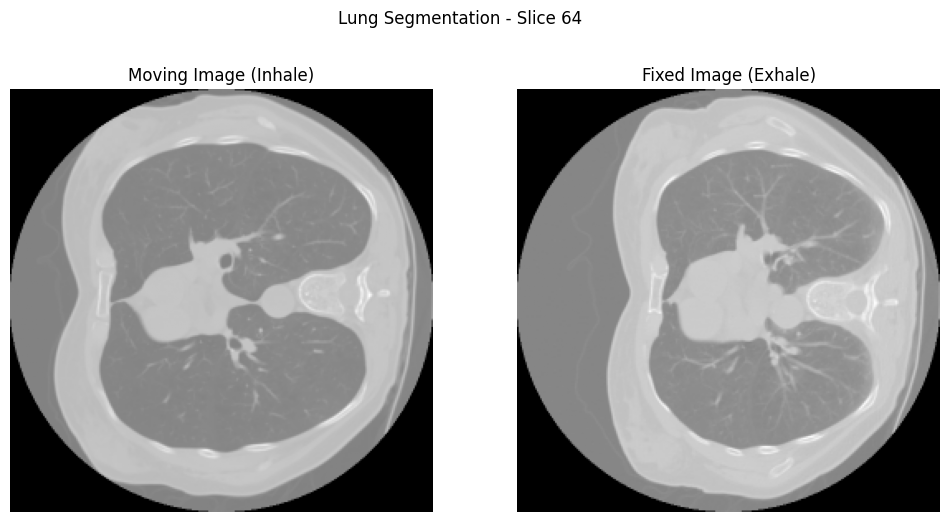

Visualizing preprocessed data for Pair 2


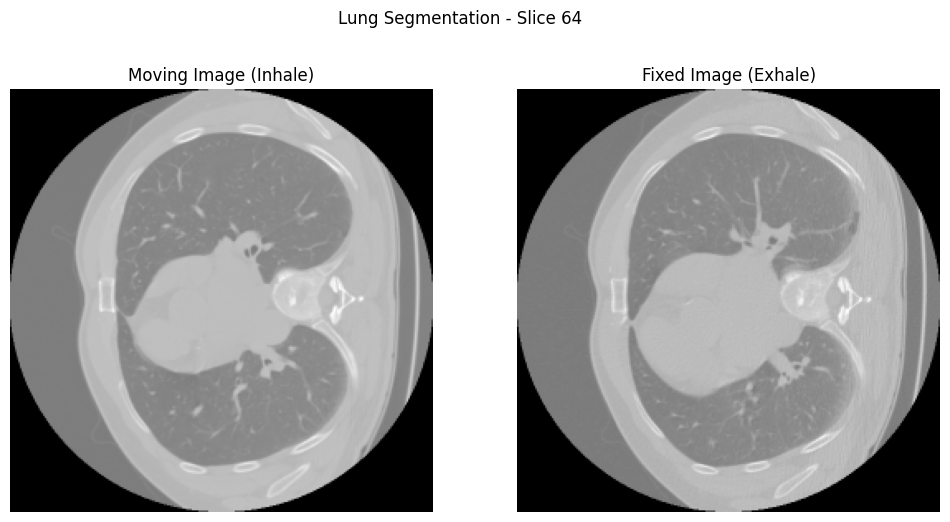

Visualizing preprocessed data for Pair 3


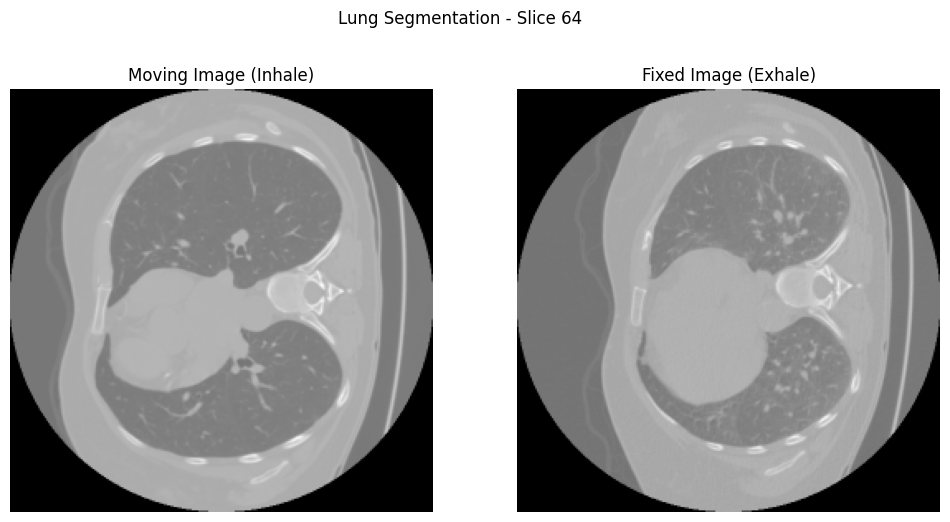

In [6]:
# Visualize the preprocessed data
for i, batch in enumerate(data_loader):
    print(f"Visualizing preprocessed data for Pair {i + 1}")
    visualize_preprocessed_data(batch)
    if i == 2:  # Display visualization for the first 3 pairs only
        break

# Training

Training Fold 0...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/100 - 2.3171 sec/step - loss: 1.2999e-01
Epoch 2/100 - 1.5447 sec/step - loss: 1.2902e-01
Epoch 3/100 - 1.2851 sec/step - loss: 1.2691e-01
Epoch 4/100 - 1.1582 sec/step - loss: 1.2198e-01
Epoch 5/100 - 1.0859 sec/step - loss: 1.1728e-01
Epoch 6/100 - 1.0387 sec/step - loss: 1.1394e-01
Epoch 7/100 - 1.0035 sec/step - loss: 1.0914e-01
Epoch 8/100 - 0.9802 sec/step - loss: 1.0331e-01
Epoch 9/100 - 0.9618 sec/step - loss: 9.8569e-02
Epoch 10/100 - 0.9481 sec/step - loss: 9.3341e-02
Epoch 11/100 - 0.9379 sec/step - loss: 8.8774e-02
Epoch 12/100 - 0.9307 sec/step - loss: 8.5062e-02
Epoch 13/100 - 0.9236 sec/step - loss: 8.1861e-02
Epoch 14/100 - 0.9184 sec/step - loss: 7.8983e-02
Epoch 15/100 - 0.9132 sec/step - loss: 7.6566e-02
Epoch 16/100 - 0.9084 sec/step - loss: 7.5026e-02
Epoch 17/100 - 0.9055 sec/step - loss: 7.3696e-02
Epoch 18/100 - 0.9019 sec/step - loss: 7.2378e-02
Epoch 19/100 - 0.8993 sec/step - loss: 7.0927e-02
Epoch 20/100 - 0.8965 sec/step - loss: 6.9745e-02
Epoch 21/

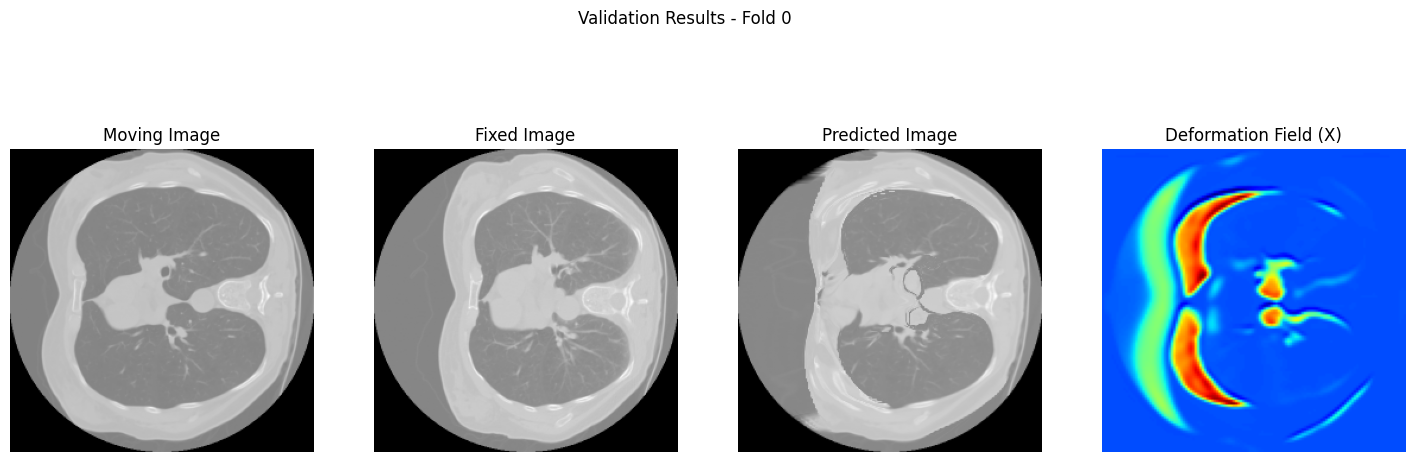

Training Fold 1...
Epoch 1/100 - 0.8474 sec/step - loss: 1.3985e-01
Epoch 2/100 - 0.8576 sec/step - loss: 1.3875e-01
Epoch 3/100 - 0.8485 sec/step - loss: 1.3565e-01
Epoch 4/100 - 0.8477 sec/step - loss: 1.3502e-01
Epoch 5/100 - 0.8478 sec/step - loss: 1.3195e-01
Epoch 6/100 - 0.8472 sec/step - loss: 1.2699e-01
Epoch 7/100 - 0.8456 sec/step - loss: 1.2295e-01
Epoch 8/100 - 0.8457 sec/step - loss: 1.1953e-01
Epoch 9/100 - 0.8464 sec/step - loss: 1.1592e-01
Epoch 10/100 - 0.8463 sec/step - loss: 1.1240e-01
Epoch 11/100 - 0.8454 sec/step - loss: 1.0939e-01
Epoch 12/100 - 0.8451 sec/step - loss: 1.0631e-01
Epoch 13/100 - 0.8445 sec/step - loss: 1.0391e-01
Epoch 14/100 - 0.8445 sec/step - loss: 1.0110e-01
Epoch 15/100 - 0.8451 sec/step - loss: 9.8528e-02
Epoch 16/100 - 0.8454 sec/step - loss: 9.6194e-02
Epoch 17/100 - 0.8453 sec/step - loss: 9.4074e-02
Epoch 18/100 - 0.8453 sec/step - loss: 9.2077e-02
Epoch 19/100 - 0.8455 sec/step - loss: 9.0266e-02
Epoch 20/100 - 0.8460 sec/step - loss: 8

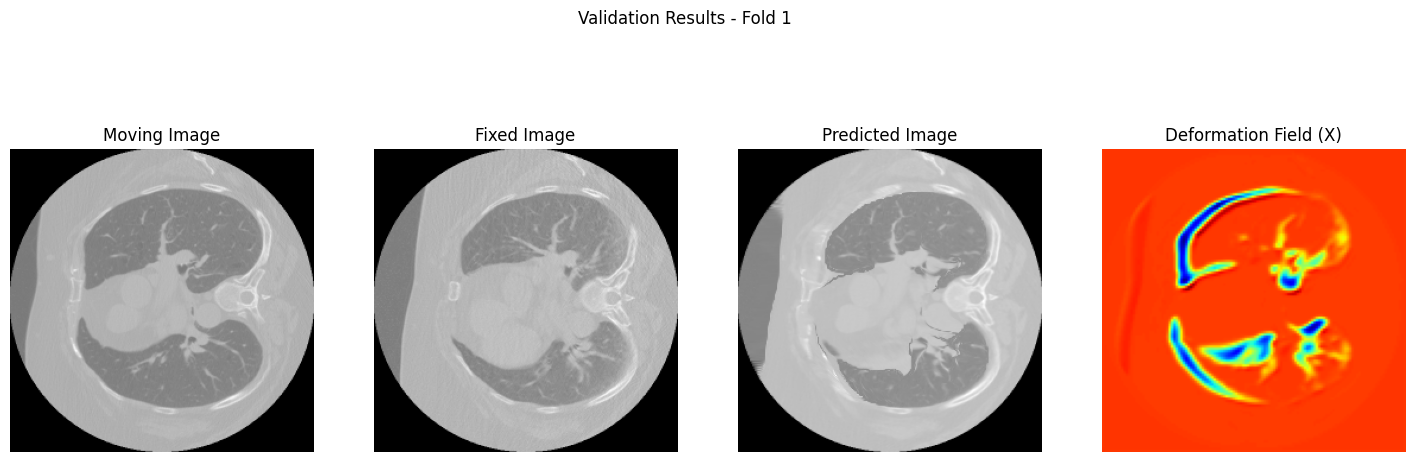

Training Fold 2...
Epoch 1/100 - 0.8434 sec/step - loss: 1.3899e-01
Epoch 2/100 - 0.8572 sec/step - loss: 1.3791e-01
Epoch 3/100 - 0.8508 sec/step - loss: 1.3527e-01
Epoch 4/100 - 0.8487 sec/step - loss: 1.3276e-01
Epoch 5/100 - 0.8524 sec/step - loss: 1.2945e-01
Epoch 6/100 - 0.8504 sec/step - loss: 1.2585e-01
Epoch 7/100 - 0.8490 sec/step - loss: 1.2163e-01
Epoch 8/100 - 0.8491 sec/step - loss: 1.1831e-01
Epoch 9/100 - 0.8485 sec/step - loss: 1.1451e-01
Epoch 10/100 - 0.8481 sec/step - loss: 1.1103e-01
Epoch 11/100 - 0.8488 sec/step - loss: 1.0777e-01
Epoch 12/100 - 0.8491 sec/step - loss: 1.0425e-01
Epoch 13/100 - 0.8485 sec/step - loss: 1.0030e-01
Epoch 14/100 - 0.8477 sec/step - loss: 9.6326e-02
Epoch 15/100 - 0.8473 sec/step - loss: 9.2477e-02
Epoch 16/100 - 0.8479 sec/step - loss: 8.9138e-02
Epoch 17/100 - 0.8481 sec/step - loss: 8.6092e-02
Epoch 18/100 - 0.8476 sec/step - loss: 8.3321e-02
Epoch 19/100 - 0.8473 sec/step - loss: 8.0683e-02
Epoch 20/100 - 0.8465 sec/step - loss: 7

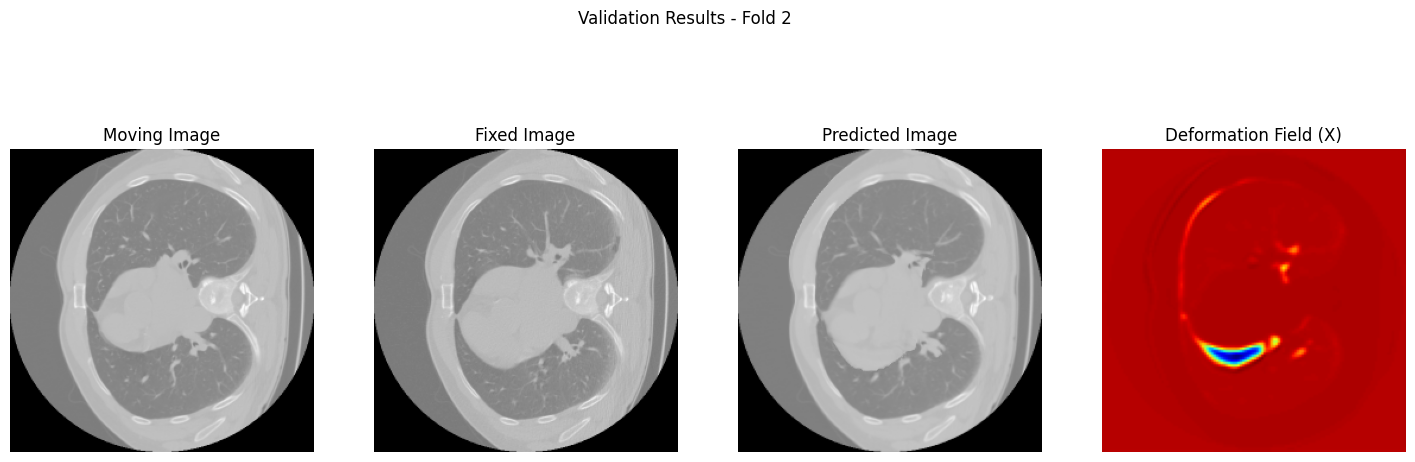

Training Fold 3...
Epoch 1/100 - 0.8442 sec/step - loss: 1.1891e-01
Epoch 2/100 - 0.8555 sec/step - loss: 1.1747e-01
Epoch 3/100 - 0.8495 sec/step - loss: 1.1431e-01
Epoch 4/100 - 0.8430 sec/step - loss: 1.0763e-01
Epoch 5/100 - 0.8440 sec/step - loss: 1.0723e-01
Epoch 6/100 - 0.8440 sec/step - loss: 1.0263e-01
Epoch 7/100 - 0.8433 sec/step - loss: 9.9053e-02
Epoch 8/100 - 0.8436 sec/step - loss: 9.6266e-02
Epoch 9/100 - 0.8429 sec/step - loss: 9.4309e-02
Epoch 10/100 - 0.8437 sec/step - loss: 9.1698e-02
Epoch 11/100 - 0.8440 sec/step - loss: 8.8887e-02
Epoch 12/100 - 0.8439 sec/step - loss: 8.7039e-02
Epoch 13/100 - 0.8444 sec/step - loss: 8.4980e-02
Epoch 14/100 - 0.8439 sec/step - loss: 8.3333e-02
Epoch 15/100 - 0.8449 sec/step - loss: 8.1848e-02
Epoch 16/100 - 0.8452 sec/step - loss: 8.0259e-02
Epoch 17/100 - 0.8444 sec/step - loss: 7.8646e-02
Epoch 18/100 - 0.8444 sec/step - loss: 7.7370e-02
Epoch 19/100 - 0.8440 sec/step - loss: 7.6112e-02
Epoch 20/100 - 0.8444 sec/step - loss: 7

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Leave-One-Out Cross Validation
for fold_idx, leave_out in enumerate(range(len(data_dicts))):
    # Split data into training and validation
    train_data = [d for i, d in enumerate(data_dicts) if i != leave_out]
    val_data = [data_dicts[leave_out]]

    # Create training loader
    train_dataset = Dataset(data=train_data, transform=transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    model = train_voxelmorph(train_loader, val_data, fold_idx, model_name='voxelmorph_loocv_pt', epochs=100)

    # Test on the left-out case
    print(f"Testing on Fold {fold_idx}: Inhale - {val_data[0]['moving']}, Exhale - {val_data[0]['fixed']}")
    validate_model(model, val_data, transforms, device, fold_idx)

Training Fold 3...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/100 - 2.3210 sec/step - loss: 1.1891e-01
Epoch 2/100 - 1.5364 sec/step - loss: 1.1747e-01
Epoch 3/100 - 1.2701 sec/step - loss: 1.1431e-01
Epoch 4/100 - 1.1395 sec/step - loss: 1.0763e-01
Epoch 5/100 - 1.0655 sec/step - loss: 1.0736e-01
Epoch 6/100 - 1.0158 sec/step - loss: 1.0284e-01
Epoch 7/100 - 0.9812 sec/step - loss: 9.9130e-02
Epoch 8/100 - 0.9564 sec/step - loss: 9.6015e-02
Epoch 9/100 - 0.9374 sec/step - loss: 9.2827e-02
Epoch 10/100 - 0.9211 sec/step - loss: 8.9911e-02
Epoch 11/100 - 0.9076 sec/step - loss: 8.7977e-02
Epoch 12/100 - 0.8966 sec/step - loss: 8.5575e-02
Epoch 13/100 - 0.8893 sec/step - loss: 8.3430e-02
Epoch 14/100 - 0.8816 sec/step - loss: 8.1434e-02
Epoch 15/100 - 0.8749 sec/step - loss: 7.9539e-02
Epoch 16/100 - 0.8687 sec/step - loss: 7.7617e-02
Epoch 17/100 - 0.8640 sec/step - loss: 7.5443e-02
Epoch 18/100 - 0.8592 sec/step - loss: 7.3441e-02
Epoch 19/100 - 0.8544 sec/step - loss: 7.1613e-02
Epoch 20/100 - 0.8507 sec/step - loss: 6.9819e-02
Epoch 21/

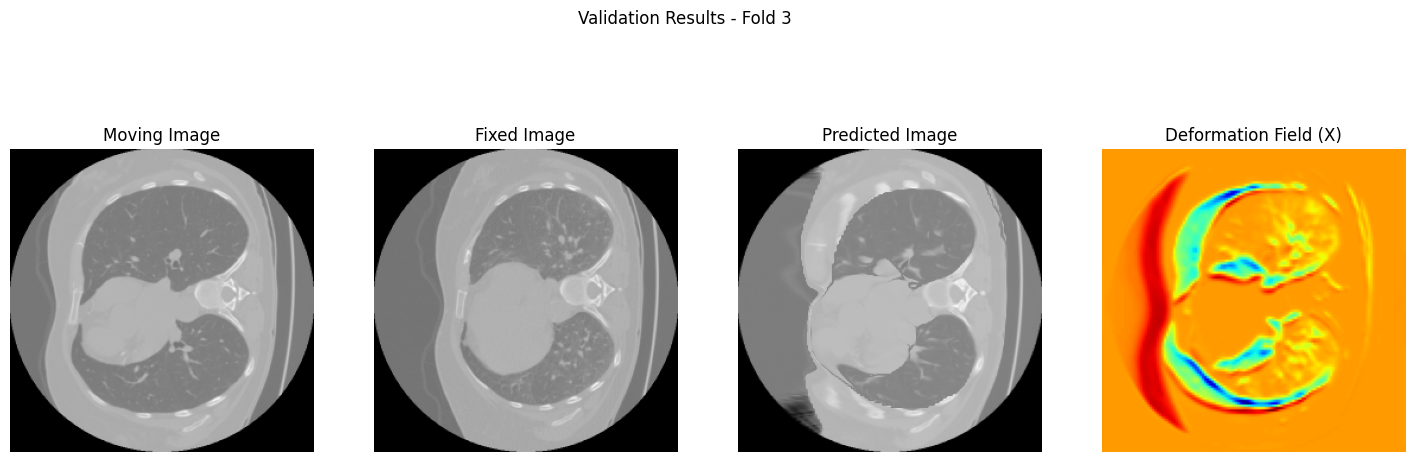

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Leave-One-Out Cross Validation
for fold_idx, leave_out in enumerate(range(len(data_dicts))):
    if fold_idx in [0, 1, 2]:
        continue
    # Split data into training and validation
    train_data = [d for i, d in enumerate(data_dicts) if i != leave_out]
    val_data = [data_dicts[leave_out]]

    # Create training loader
    train_dataset = Dataset(data=train_data, transform=transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    model = train_voxelmorph(train_loader, val_data, fold_idx, model_name='voxelmorph_loocv_pt', epochs=100)

    # Test on the left-out case
    print(f"Testing on Fold {fold_idx}: Inhale - {val_data[0]['moving']}, Exhale - {val_data[0]['fixed']}")
    validate_model(model, val_data, transforms, device, fold_idx)

Training Fold 0...
Epoch 1/100 - 0.7626 sec/step - loss: 1.2321e-01
Epoch 2/100 - 0.7760 sec/step - loss: 1.2254e-01
Epoch 3/100 - 0.7817 sec/step - loss: 1.2117e-01
Epoch 4/100 - 0.7801 sec/step - loss: 1.1970e-01
Epoch 5/100 - 0.7858 sec/step - loss: 1.1639e-01
Epoch 6/100 - 0.7857 sec/step - loss: 1.1595e-01
Epoch 7/100 - 0.7896 sec/step - loss: 1.1494e-01
Epoch 8/100 - 0.7931 sec/step - loss: 1.1279e-01
Epoch 9/100 - 0.7919 sec/step - loss: 1.1099e-01
Epoch 10/100 - 0.7912 sec/step - loss: 1.1004e-01
Epoch 11/100 - 0.7912 sec/step - loss: 1.0847e-01
Epoch 12/100 - 0.7901 sec/step - loss: 1.0861e-01
Epoch 13/100 - 0.7895 sec/step - loss: 1.0763e-01
Epoch 14/100 - 0.7896 sec/step - loss: 1.0633e-01
Epoch 15/100 - 0.7892 sec/step - loss: 1.0509e-01
Epoch 16/100 - 0.7894 sec/step - loss: 1.0393e-01
Epoch 17/100 - 0.7900 sec/step - loss: 1.0282e-01
Epoch 18/100 - 0.7901 sec/step - loss: 1.0161e-01
Epoch 19/100 - 0.7903 sec/step - loss: 1.0074e-01
Epoch 20/100 - 0.7898 sec/step - loss: 9

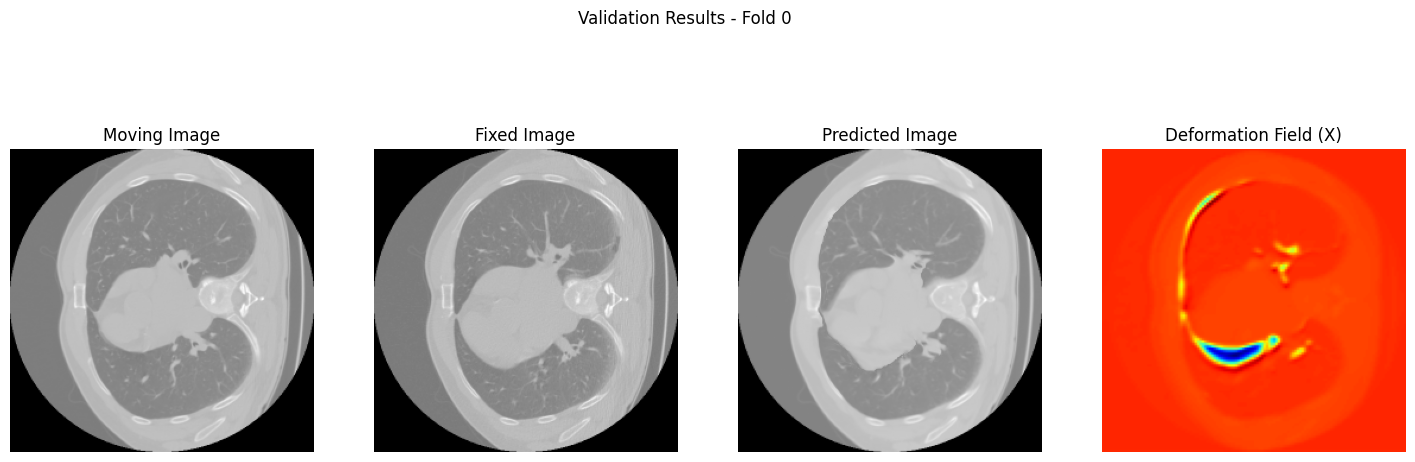

Training Fold 1...
Epoch 1/100 - 0.7763 sec/step - loss: 1.4124e-01
Epoch 2/100 - 0.7779 sec/step - loss: 1.4067e-01
Epoch 3/100 - 0.7758 sec/step - loss: 1.3932e-01
Epoch 4/100 - 0.7808 sec/step - loss: 1.3732e-01
Epoch 5/100 - 0.7793 sec/step - loss: 1.3143e-01
Epoch 6/100 - 0.7818 sec/step - loss: 1.2439e-01
Epoch 7/100 - 0.7823 sec/step - loss: 1.2990e-01
Epoch 8/100 - 0.7825 sec/step - loss: 1.2247e-01
Epoch 9/100 - 0.7836 sec/step - loss: 1.1832e-01
Epoch 10/100 - 0.7834 sec/step - loss: 1.1545e-01
Epoch 11/100 - 0.7846 sec/step - loss: 1.1267e-01
Epoch 12/100 - 0.7862 sec/step - loss: 1.1010e-01
Epoch 13/100 - 0.7854 sec/step - loss: 1.0769e-01
Epoch 14/100 - 0.7849 sec/step - loss: 1.0556e-01
Epoch 15/100 - 0.7852 sec/step - loss: 1.0360e-01
Epoch 16/100 - 0.7860 sec/step - loss: 1.0174e-01
Epoch 17/100 - 0.7858 sec/step - loss: 9.9965e-02
Epoch 18/100 - 0.7856 sec/step - loss: 9.8294e-02
Epoch 19/100 - 0.7858 sec/step - loss: 9.6695e-02
Epoch 20/100 - 0.7855 sec/step - loss: 9

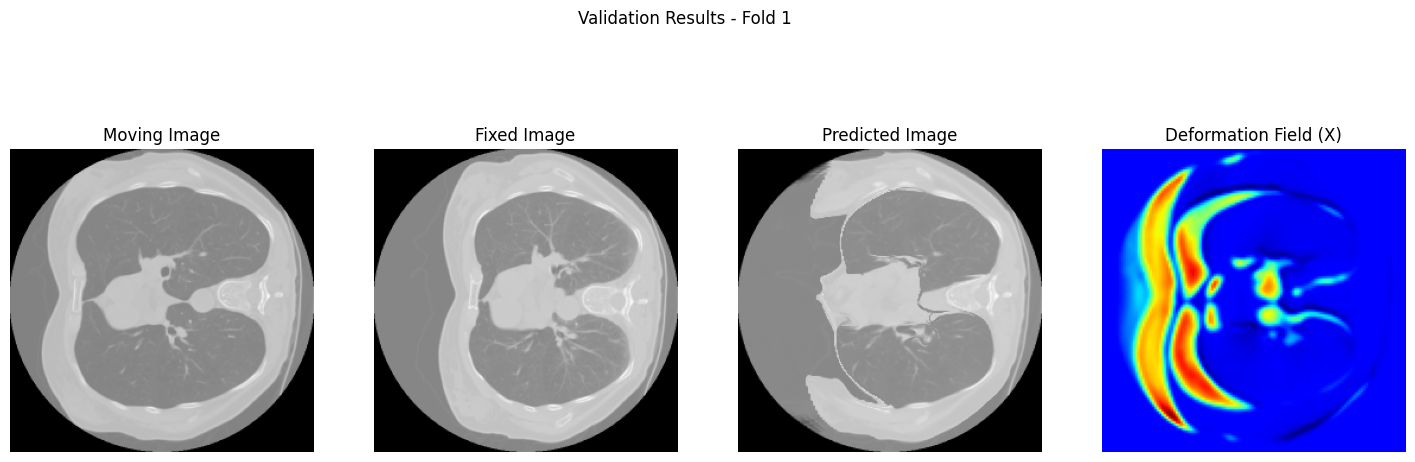

In [17]:
# 2-Fold Cross Validation
num_folds = 2
for fold_idx in range(num_folds):
    # Split data into training and validation
    if fold_idx == 0:
        train_data = data_dicts[:2]  # First 2 images for training
        val_data = data_dicts[2:]   # Last 2 images for validation
    else:
        train_data = data_dicts[2:]  # Last 2 images for training
        val_data = data_dicts[:2]   # First 2 images for validation

    # Create training loader
    train_dataset = Dataset(data=train_data, transform=transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    model = train_voxelmorph(train_loader, val_data, fold_idx, model_name='voxelmorph_2fcv_pt', epochs=100)

    # Test on the left-out case
    print(f"Testing on Fold {fold_idx}: Inhale - {val_data[0]['moving']}, Exhale - {val_data[0]['fixed']}")
    validate_model(model, val_data, transforms, device, fold_idx)

# Evaluation

In [10]:
image_size = (256, 256, 128)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_voxelmorph_model(image_size, enc_nf, dec_nf).to(device)

In [52]:
def transform_landmarks(model, moving_image_path, fixed_image_path, moving_landmarks, fixed_landmarks, image_spacing, patient_num):
    """Transforms moving landmarks to the fixed image space using the trained model, computing TRE before and after registration.

    Args:
        model: The trained VoxelMorph model.
        moving_image_path: Path to the moving image.
        fixed_image_path: Path to the fixed image.
        moving_landmarks: NumPy array of shape (N, 3) representing moving landmarks.
        fixed_landmarks: NumPy array of shape (N, 3) representing fixed landmarks.

    Returns:
        NumPy array of shape (N, 3) representing the transformed landmarks.
    """
    # 1. Load and preprocess images
    transforms = monai.transforms.Compose([
        LoadImageD(keys=["moving", "fixed"]),
        EnsureChannelFirstD(keys=["moving", "fixed"]),
        NormalizeIntensityD(keys=["moving", "fixed"], nonzero=True, channel_wise=True),
        ResizeD(keys=["moving", "fixed"], spatial_size=(256, 256, 128)),  # Resize for computational efficiency
        ToTensorD(keys=["moving", "fixed"]),
    ])

    data_dict = {"moving": moving_image_path, "fixed": fixed_image_path}
    data = transforms(data_dict)
    moving_image = data["moving"].unsqueeze(0).to(device)  # Add batch dimension
    fixed_image = data["fixed"].unsqueeze(0).to(device)    # Add batch dimension

    # 2. Get the displacement field
    with torch.no_grad():
        _, displacement_field = model(moving_image, fixed_image)

    # 3. Transform landmarks and calculate TRE
    transformed_landmarks = []
    tre_values_before = []  # TRE before registration
    tre_values_after = []   # TRE after registration

    # Get original and resized image size
    original_image_size = sitk.ReadImage(moving_image_path).GetSize()
    resized_image_size = (256, 256, 128)  # Resize dimensions set earlier

    for landmark in moving_landmarks:
        # Scale landmark coordinates to the resized image space
        x, y, z = landmark.astype(float)
        x_rescaled = x * resized_image_size[0] / original_image_size[0]  # Scale x coordinate
        y_rescaled = y * resized_image_size[1] / original_image_size[1]  # Scale y coordinate
        z_rescaled = z * resized_image_size[2] / original_image_size[2]  # Scale z coordinate

        # Ensure coordinates are within bounds of the displacement field
        x_rescaled = np.clip(x_rescaled, 0, displacement_field.shape[2] - 1)
        y_rescaled = np.clip(y_rescaled, 0, displacement_field.shape[3] - 1)
        z_rescaled = np.clip(z_rescaled, 0, displacement_field.shape[4] - 1)

        # Get displacement from the displacement field (assume [batch, channels, x, y, z])
        displacement = displacement_field[0, :, int(x_rescaled), int(y_rescaled), int(z_rescaled)].cpu().numpy()

        # Apply displacement to the landmark to get the transformed landmark
        transformed_landmark = landmark + displacement
        transformed_landmarks.append(transformed_landmark)

        # Find the corresponding fixed landmark (assumption: landmarks are in the same order)
        fixed_landmark = fixed_landmarks[np.where((moving_landmarks == landmark).all(axis=1))[0][0]]

        # Calculate TRE before registration (moving landmark vs fixed landmark)
        tre_before = np.sqrt(np.sum(((landmark - fixed_landmark) * image_spacing)**2))
        tre_values_before.append(tre_before)

        # Calculate TRE after registration (transformed landmark vs fixed landmark)
        tre_after = np.sqrt(np.sum(((transformed_landmark - fixed_landmark) * image_spacing)**2))
        tre_values_after.append(tre_after)

    # Calculate mean and standard deviation of TRE before and after registration
    mean_tre_before = np.mean(tre_values_before)
    std_tre_before = np.std(tre_values_before)

    mean_tre_after = np.mean(tre_values_after)
    std_tre_after = np.std(tre_values_after)

    # Print results
    print(f"Before Registration - Mean TRE: {mean_tre_before}, Standard Deviation: {std_tre_before} for patient {patient_num}")
    print(f"After Registration - Mean TRE: {mean_tre_after}, Standard Deviation: {std_tre_after} for patient {patient_num}")

    return np.array(transformed_landmarks), mean_tre_after, std_tre_after


In [23]:
def transform_landmarks(model, moving_image_path, fixed_image_path, moving_landmarks, fixed_landmarks, image_spacing, patient_num):
    """Transforms moving landmarks to the fixed image space using the trained model, computing TRE before and after registration.

    Args:
        model: The trained VoxelMorph model.
        moving_image_path: Path to the moving image.
        fixed_image_path: Path to the fixed image.
        moving_landmarks: NumPy array of shape (N, 3) representing moving landmarks.
        fixed_landmarks: NumPy array of shape (N, 3) representing fixed landmarks.

    Returns:
        NumPy array of shape (N, 3) representing the transformed landmarks.
    """
    # 1. Load and preprocess images
    transforms = monai.transforms.Compose([
        LoadImageD(keys=["moving", "fixed"]),
        EnsureChannelFirstD(keys=["moving", "fixed"]),
        NormalizeIntensityD(keys=["moving", "fixed"], nonzero=True, channel_wise=True),
        ResizeD(keys=["moving", "fixed"], spatial_size=(256, 256, 128)),  # Resize for computational efficiency
        ToTensorD(keys=["moving", "fixed"]),
    ])

    data_dict = {"moving": moving_image_path, "fixed": fixed_image_path}
    data = transforms(data_dict)
    moving_image = data["moving"].unsqueeze(0).to(device)  # Add batch dimension
    fixed_image = data["fixed"].unsqueeze(0).to(device)    # Add batch dimension

    # 2. Get the displacement field
    with torch.no_grad():
        prediction, displacement_field_ = model(moving_image, fixed_image)

    # 3. Transform landmarks and calculate TRE
    transformed_landmarks = []
    tre_values_before = []  # TRE before registration
    tre_values_after = []   # TRE after registration

    # Get original and resized image size
    original_image_size = sitk.ReadImage(moving_image_path).GetSize()

    # resize the displacement to the original image size
    displacement_field = torch.nn.functional.interpolate(displacement_field_, size=original_image_size, mode='trilinear', align_corners=False)
    # plot the inputs, prediction and both deformation
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(moving_image.cpu().detach().numpy()[0, 0, :, :, 64], cmap="gray")
    plt.title("Moving Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(fixed_image.cpu().detach().numpy()[0, 0, :, :, 64], cmap="gray")
    plt.title("Fixed Image")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(prediction.cpu().detach().numpy()[0, 0, :, :, 64], cmap="gray")
    plt.title("Predicted Image")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(displacement_field.cpu().detach().numpy()[0, 0, :, :, 32], cmap="jet")
    plt.title("Displacement Image Resized")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(displacement_field_.cpu().detach().numpy()[0, 0, :, :, 32], cmap="jet")
    plt.title("Displacement Image Original")
    plt.axis("off")

    plt.suptitle(f"Validation Results")
    plt.show()


    for landmark in moving_landmarks:
        # Scale landmark coordinates to the resized image space
        x, y, z = landmark.astype(float)

        # Get displacement from the displacement field (assume [batch, channels, x, y, z])
        displacement = displacement_field[0, :, int(x), int(y), int(z)].cpu().numpy()

        # Apply displacement to the landmark to get the transformed landmark
        transformed_landmark = landmark + displacement
        transformed_landmarks.append(transformed_landmark)

        # Find the corresponding fixed landmark (assumption: landmarks are in the same order)
        fixed_landmark = fixed_landmarks[np.where((moving_landmarks == landmark).all(axis=1))[0][0]]

        # Calculate TRE before registration (moving landmark vs fixed landmark)
        tre_before = np.sqrt(np.sum(((landmark - fixed_landmark) * image_spacing)**2))
        tre_values_before.append(tre_before)

        # Calculate TRE after registration (transformed landmark vs fixed landmark)
        tre_after = np.sqrt(np.sum(((transformed_landmark - fixed_landmark) * image_spacing)**2))
        tre_values_after.append(tre_after)

    # Calculate mean and standard deviation of TRE before and after registration
    mean_tre_before = np.mean(tre_values_before)
    std_tre_before = np.std(tre_values_before)

    mean_tre_after = np.mean(tre_values_after)
    std_tre_after = np.std(tre_values_after)

    # Print results
    print(f"Before Registration - Mean TRE: {mean_tre_before}, Standard Deviation: {std_tre_before} for patient {patient_num}")
    print(f"After Registration - Mean TRE: {mean_tre_after}, Standard Deviation: {std_tre_after} for patient {patient_num}")

    return np.array(transformed_landmarks), mean_tre_after, std_tre_after


<ipython-input-24-4fba63d4bc0b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


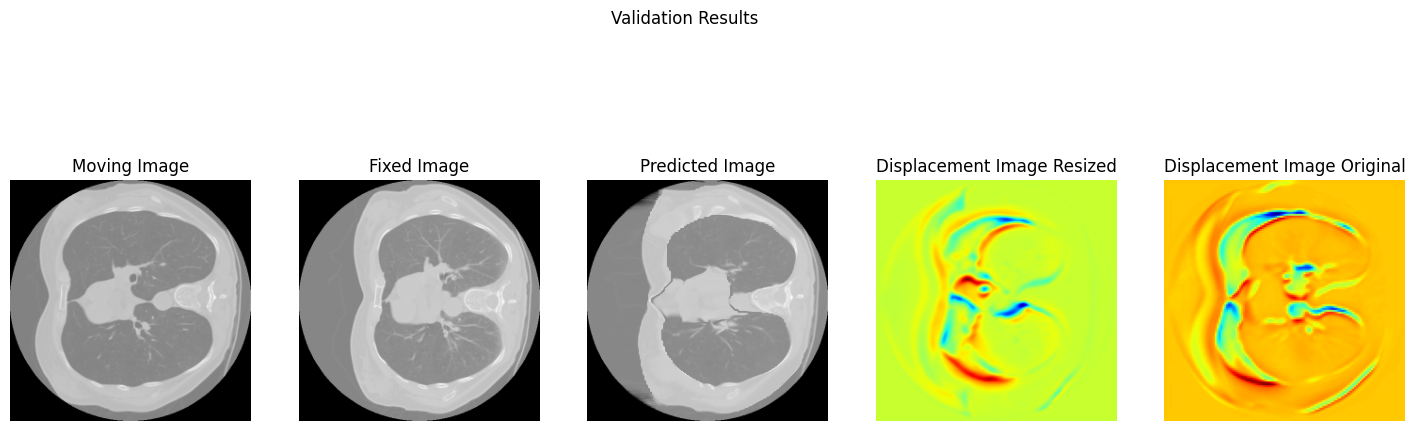

Before Registration - Mean TRE: 26.14727642316542, Standard Deviation: 11.337751966354611 for patient 1
After Registration - Mean TRE: 21.847289908434412, Standard Deviation: 10.78075792708017 for patient 1


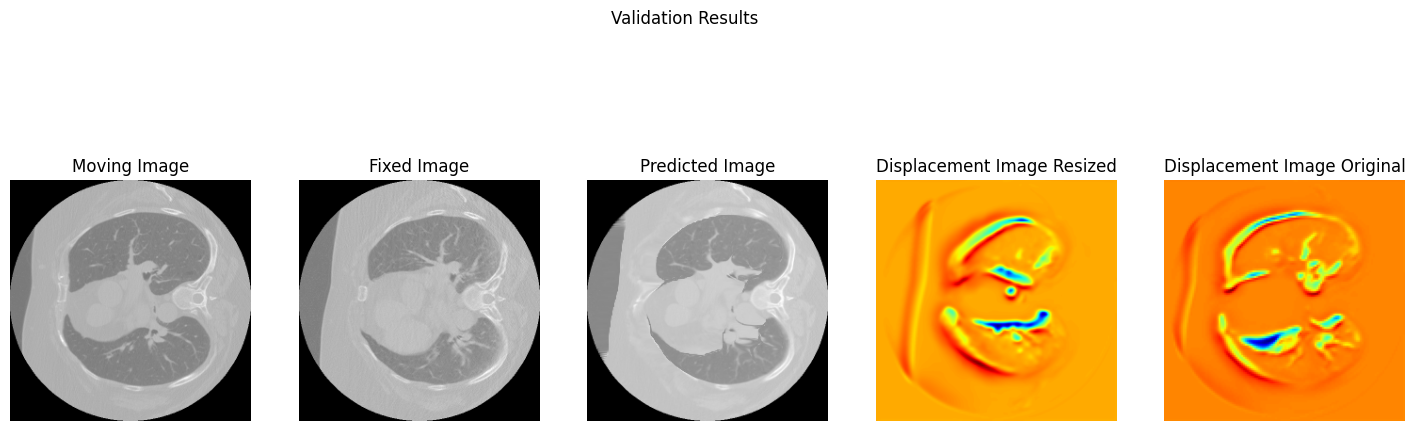

Before Registration - Mean TRE: 21.64084010925038, Standard Deviation: 6.415267676867443 for patient 2
After Registration - Mean TRE: 20.905458659734503, Standard Deviation: 7.335036526569737 for patient 2


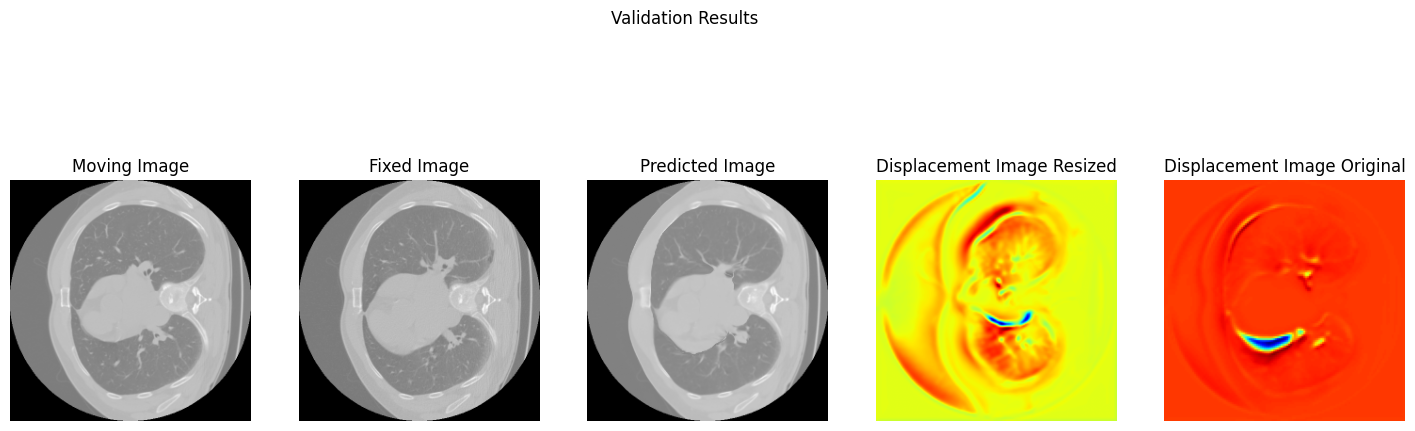

Before Registration - Mean TRE: 12.625883510427451, Standard Deviation: 6.381867457710387 for patient 3
After Registration - Mean TRE: 14.015907795723452, Standard Deviation: 8.673435035801392 for patient 3


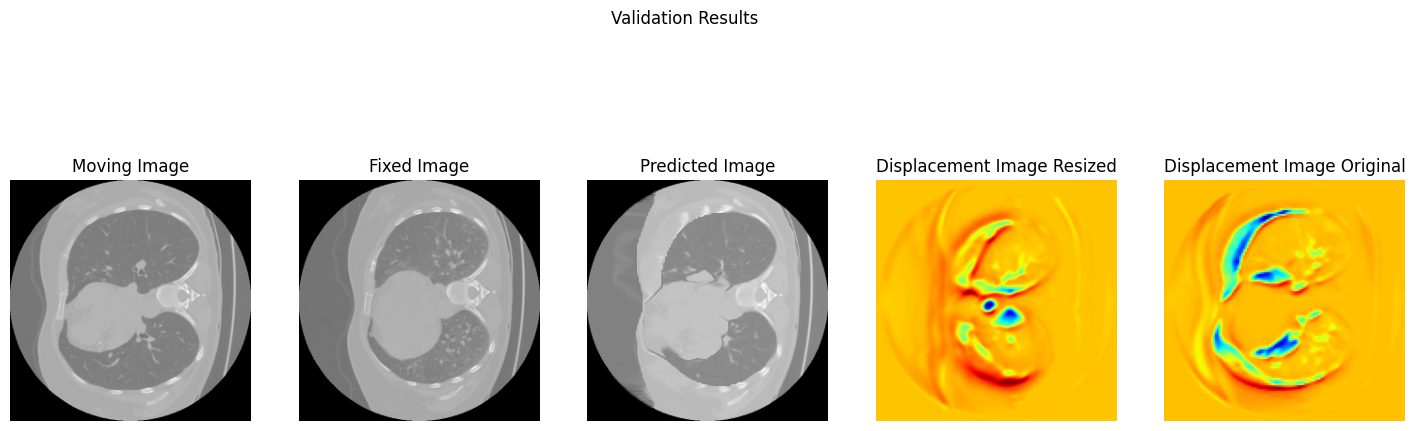

Before Registration - Mean TRE: 29.583560337310402, Standard Deviation: 12.924171066985867 for patient 4
After Registration - Mean TRE: 24.194697488983305, Standard Deviation: 9.783623919997508 for patient 4


In [24]:
# best fold of LOOCV
model_path = f'{root_path}voxelmorph_loocv_pt2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
for patient_num in range(1,5):
    fixed_image_path = f"{root_path}data/copd{patient_num}/copd{patient_num}_eBHCT.nii.gz"
    moving_image_path = f"{root_path}data/copd{patient_num}/copd{patient_num}_iBHCT.nii.gz"
    fixed_landmarks = np.loadtxt(f"{root_path}data/copd{patient_num}/copd{patient_num}_300_eBH_xyz_r1.txt")
    moving_landmarks = np.loadtxt(f"{root_path}data/copd{patient_num}/copd{patient_num}_300_iBH_xyz_r1.txt")
    if patient_num == 1:
        image_spacing = [0.62, 0.62, 2.5]
    elif patient_num == 2:
        image_spacing = [0.64, 0.64, 2.5]
    elif patient_num == 3:
        image_spacing = [0.65, 0.65, 2.5]
    else:
        image_spacing = [0.59, 0.59, 2.5]
    landmarks, mean_tre, std_tre = transform_landmarks(model, moving_image_path, fixed_image_path, moving_landmarks, fixed_landmarks, image_spacing, patient_num)

In [14]:
# best fold of 2FCV
model_path = f'{root_path}voxelmorph_2fcv_pt0.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
for patient_num in range(1,5):
    fixed_image_path = f"{root_path}data/copd{patient_num}/copd{patient_num}_eBHCT.nii.gz"
    moving_image_path = f"{root_path}data/copd{patient_num}/copd{patient_num}_iBHCT.nii.gz"
    fixed_landmarks = np.loadtxt(f"{root_path}data/copd{patient_num}/copd{patient_num}_300_eBH_xyz_r1.txt")
    moving_landmarks = np.loadtxt(f"{root_path}data/copd{patient_num}/copd{patient_num}_300_iBH_xyz_r1.txt")
    if patient_num == 1:
        image_spacing = [0.62, 0.62, 2.5]
    elif patient_num == 2:
        image_spacing = [0.64, 0.64, 2.5]
    elif patient_num == 3:
        image_spacing = [0.65, 0.65, 2.5]
    else:
        image_spacing = [0.59, 0.59, 2.5]
    landmarks, mean_tre, std_tre = transform_landmarks(model, moving_image_path, fixed_image_path, moving_landmarks, fixed_landmarks, image_spacing, patient_num)

<ipython-input-14-9f841ee8e249>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Before Registration - Mean TRE: 26.14727642316542, Standard Deviation: 11.337751966354611 for patient 1
After Registration - Mean TRE: 36.153838118894924, Standard Deviation: 26.73938905982233 for patient 1
Before Registration - Mean TRE: 21.64084010925038, Standard Deviation: 6.415267676867443 for patient 2
After Registration - Mean TRE: 27.422490142699463, Standard Deviation: 18.491151175419887 for patient 2
Before Registration - Mean TRE: 12.625883510427451, Standard Deviation: 6.381867457710387 for patient 3
After Registration - Mean TRE: 12.140257085401705, Standard Deviation: 6.527573850758187 for patient 3
Before Registration - Mean TRE: 29.583560337310402, Standard Deviation: 12.924171066985867 for patient 4
After Registration - Mean TRE: 29.348685169502883, Standard Deviation: 18.98835494444781 for patient 4
